# Example of using PySpark to do data analysis with dataframe

## Imports and variables

In [4]:
from pyspark import SparkConf, SparkContext                    
from mmtfPyspark.io import mmtfReader                                
from mmtfPyspark.webFilters import Pisces                        
from mmtfPyspark.datasets import groupInteractionExtractor
from mmtfPyspark.structureViewer import interaction_structure_viewer
import matplotlib.pyplot as plt
import pandas as pd
import py3Dmol
import time
                                                               
# Create variables                                             
APP_NAME = "MMTF_Spark"                                        
path = "./resources/mmtf_full_sample/"                            

# Configure Spark                                              
conf = SparkConf().setAppName(APP_NAME).setMaster("local[*]")  
sc = SparkContext(conf=conf)                                   

## Read PDB and create PISCES non-redundant set

In [5]:
pdb = mmtfReader.read_sequence_file(path, sc)
pdb = pdb.filter(Pisces(sequenceIdentity = 20, resolution = 2.0))         

## Extract Zinc interactions

In [6]:
finder = groupInteractionExtractor("ZN", distance = 3.0)       
interactions = finder.get_dataset(pdb)

interactions.show(10)

+-----------+--------+-----+--------+------+--------+-----+--------+------+---------+
|structureId|residue1|atom1|element1|index1|residue2|atom2|element2|index2| distance|
+-----------+--------+-----+--------+------+--------+-----+--------+------+---------+
|       3U9W|      ZN|   ZN|      Zn|   608|     HIS|  NE2|       N|   292|2.0088096|
|       3U9W|      ZN|   ZN|      Zn|   608|     HIS|  CE1|       C|   296|2.9138267|
|       3U9W|      ZN|   ZN|      Zn|   608|     HIS|  NE2|       N|   296|1.9654061|
|       3U9W|      ZN|   ZN|      Zn|   608|     GLU|   CD|       C|   315|2.7459066|
|       3U9W|      ZN|   ZN|      Zn|   608|     GLU|  OE1|       O|   315|1.9810634|
|       3U9W|      ZN|   ZN|      Zn|   608|     GLU|  OE2|       O|   315|2.9121115|
|       3U9W|      ZN|   ZN|      Zn|   608|     28P|  CAD|       C|   615|2.6070845|
|       3U9W|      ZN|   ZN|      Zn|   608|     28P|  OAF|       O|   615|2.6068592|
|       3U9W|      ZN|   ZN|      Zn|   608|     28P| 

## Get unique PDBIds from result

In [7]:
# Get list of PDBids
pdbIds = [row.structureId for row in interactions.collect()]

# Get unique pdbIds and convert back to list
unique_pdbIds = list(set(pdbIds))

## Visualize first hit

In [8]:
interaction_structure_viewer(unique_pdbIds, 'ZN', style='cartoon')

interactive(children=(IntSlider(value=0, description='i', max=472), Output()), _dom_classes=('widget-interact',))

<function mmtfPyspark.structureViewer.interaction_structure_viewer.<locals>.view3d>

## Show top 10 interacting groups                           


In [9]:
df = interactions.filter("element2 != 'C'")\
                 .groupBy("residue2")\
                 .count()\
                 .sort("count", ascending=False)\
                 .toPandas()
df.head(10)

,residue2,count
0,CYS,1436
1,HIS,1273
2,HOH,971
3,GLU,723
4,ASP,715
5,ACT,79
6,CAC,43
7,PO4,42
8,ZN,38
9,CL,38


## Plot histogram for top 10 interacting groups

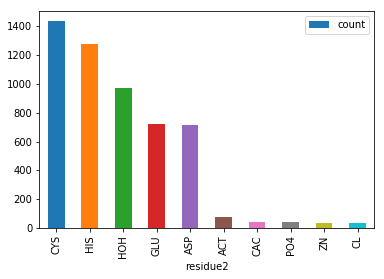

In [12]:
df.head(10).plot(x='residue2', y='count', kind='bar')

In [11]:
sc.stop()